# Preliminary Work

Let's check for multicollinearity and make sure to drop 1 dummy from each category.

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.formula.api import ols
from scipy.stats import stats
import statsmodels.stats.api as sms

sns.set_style('darkgrid')

In [2]:
# importing data
df = pd.read_csv('csv_files/new_kc_house_data_clean_with_dummies2.csv')
df = df.drop(['Unnamed: 0','id'], axis=1)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,sqft_above,yr_built,zipcode,lat,long,...,grd_12_to_13,jan_mar,apr_jun,jul_sep,oct_dec,cond_poor,cond_fair,cond_average,cond_good,cond_very_good
0,221900.0,3,1.00,1180,5650,1180,55,66,47.5112,-122.257,...,0,0,0,0,1,0,0,1,0,0
1,205425.0,2,1.00,880,6780,880,45,66,47.5009,-122.248,...,0,0,1,0,0,0,0,0,1,0
2,445000.0,3,2.25,2100,8201,1620,67,66,47.5091,-122.244,...,0,0,0,1,0,0,0,1,0,0
3,236000.0,3,1.00,1300,5898,1300,61,66,47.5053,-122.255,...,0,0,0,1,0,0,0,1,0,0
4,170000.0,2,1.00,860,5265,860,31,66,47.5048,-122.272,...,0,1,0,0,0,0,0,1,0,0


In [3]:
# label encode city column
df['city'] = df['city'].astype('category')
df['city'] = df.city.cat.codes

## Checking for Multicollinearity

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21420 entries, 0 to 21419
Data columns (total 41 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            21420 non-null  float64
 1   bedrooms         21420 non-null  int64  
 2   bathrooms        21420 non-null  float64
 3   sqft_living      21420 non-null  int64  
 4   sqft_lot         21420 non-null  int64  
 5   sqft_above       21420 non-null  int64  
 6   yr_built         21420 non-null  int64  
 7   zipcode          21420 non-null  int64  
 8   lat              21420 non-null  float64
 9   long             21420 non-null  float64
 10  sqft_living15    21420 non-null  int64  
 11  sqft_lot15       21420 non-null  int64  
 12  waterfront_N     21420 non-null  int64  
 13  waterfront_Y     21420 non-null  int64  
 14  not_renovated    21420 non-null  int64  
 15  is_renovated     21420 non-null  int64  
 16  floors_1         21420 non-null  int64  
 17  floors_2    

<AxesSubplot:>

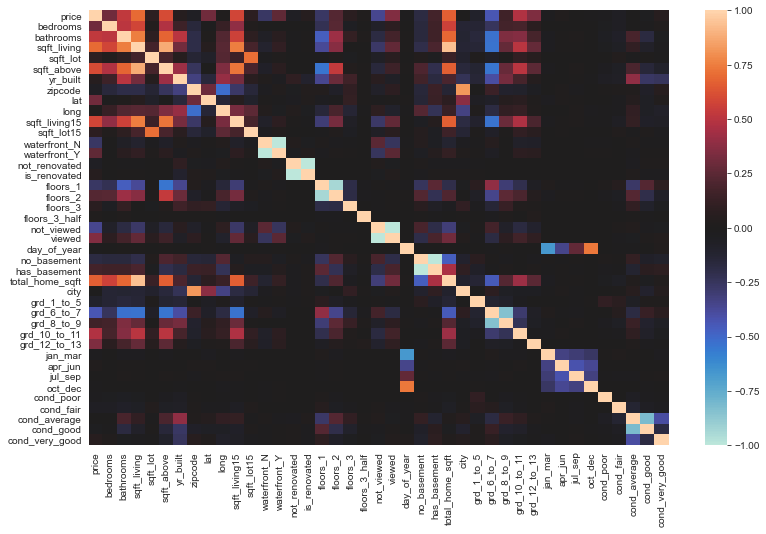

In [5]:
# checking heatmap for new correlations 
fig = plt.figure(figsize=(13,8))
sns.heatmap(data=df.corr(), center=0)

In [6]:
# creating a date frame that only contains the pairs of values with highest 
# correlation

# converts all elements to absolute values, stacks into multi-index, resets 
# the index to set the multi-index to seperate columns, and finally sorts them
corr_pairs = df.corr().abs().stack().reset_index().sort_values(0, 
                                                                ascending=False)
# zipping the variable name columns
corr_pairs['pairs'] = list(zip(corr_pairs.level_0, corr_pairs.level_1))

#set index to the pairs
pairs_index = corr_pairs.set_index(['pairs'])

#dropping level columns
pairs = pairs_index.drop(columns=['level_0', 'level_1'])

#renaming column for comprehension
pairs.columns = ['correlation']
#Since our heatmap shows that our variables only show perfect correlation with 
#themselves, we'll drop duplicates
unique_pairs = pairs.drop_duplicates()

In [7]:
unique_pairs[(unique_pairs.correlation>0.75) & (unique_pairs.correlation<1)]

,correlation
pairs,
"(total_home_sqft, sqft_living)",0.941129
"(floors_2, floors_1)",0.929959
"(sqft_living, sqft_above)",0.876533
"(grd_6_to_7, grd_8_to_9)",0.836263
"(zipcode, city)",0.825704
"(cond_good, cond_average)",0.813095
"(sqft_living15, sqft_living)",0.756186
"(bathrooms, sqft_living)",0.755522


In [8]:
# making a list of items to drop
to_drop = ['price','sqft_living','floors_2','grd_8_to_9','cond_good',
           'has_basement','waterfront_N','not_viewed','jan_mar', 
           'not_renovated', 'city']

X = ['sqft_living','floors_1','grd_8_to_9','cond_good',
           'no_basement','waterfront_N','not_viewed','jan_mar', 
           'not_renovated', 'city']

# Modeling

In [9]:
target = 'price'

feats = df.drop(to_drop, axis=1).columns
preds = '+'.join(feats)

formula = target + '~' + preds
model = smf.ols(formula=formula, data=df).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Results: Ordinary least squares
=========================================================================================
Model:                     OLS                     Adj. R-squared:            0.712      
Dependent Variable:        price                   AIC:                       583141.1966
Date:                      2021-02-25 12:11        BIC:                       583388.3310
No. Observations:          21420                   Log-Likelihood:            -2.9154e+05
Df Model:                  30                      F-statistic:               1765.      
Df Residuals:              21389                   Prob (F-statistic):        0.00       
R-squared:                 0.712                   Scale:                     3.8922e+10 
-----------------------------------------------------------------------------------------
                    Coef.        Std.Err.      t     P>|t|      [0.025         0.975]    
-----------------------------------------------------------------------------------------
Intercept       -56717193.8338 1671930.2222 -33.9232 0.0000 -59994302.2994 -53440085.3683
bedrooms           -27423.1946    1899.2948 -14.4386 0.0000    -31145.9545    -23700.4346
bathrooms           49034.0275    3198.9881  15.3280 0.0000     42763.7712     55304.2837
sqft_lot                0.1123       0.0471   2.3858 0.0171         0.0200         0.2045
sqft_above            102.1866       4.4932  22.7424 0.0000        93.3796       110.9936
yr_built            -2205.3207      68.0264 -32.4186 0.0000     -2338.6576     -2071.9838
zipcode             -1752.0422      88.5494 -19.7860 0.0000     -1925.6057     -1578.4788
lat                639466.9539   10663.9183  59.9655 0.0000    618564.8753    660369.0324
long              -218067.6421   12728.4204 -17.1323 0.0000   -243016.2995   -193118.9848
sqft_living15          42.2421       3.3810  12.4940 0.0000        35.6151        48.8691
sqft_lot15             -0.4062       0.0720  -5.6435 0.0000        -0.5473        -0.2651
waterfront_Y       667421.1805   17016.6231  39.2217 0.0000    634067.3246    700775.0364
is_renovated        12444.4863    3334.5390   3.7320 0.0002      5908.5401     18980.4325
floors_1           -11793.0503    3662.0537  -3.2203 0.0013    -18970.9498     -4615.1509
floors_3            77550.3377    7815.0089   9.9233 0.0000     62232.3350     92868.3404
floors_3_half      102338.7261   74714.2234   1.3697 0.1708    -44106.7481    248784.2002
viewed             119704.5145    5110.5303  23.4231 0.0000    109687.4923    129721.5366
day_of_year          -145.9576      52.6658  -2.7714 0.0056      -249.1865       -42.7287
no_basement         -7929.1604    5141.2325  -1.5423 0.1230    -18006.3613      2148.0405
total_home_sqft        71.2904       3.0651  23.2586 0.0000        65.2825        77.2982
grd_1_to_5        -102188.9163   13238.2041  -7.7192 0.0000   -128136.7880    -76241.0446
grd_6_to_7         -66286.3255    3736.6052 -17.7397 0.0000    -73610.3516    -58962.2994
grd_10_to_11       249479.7891    6504.3730  38.3557 0.0000    236730.7308    262228.8474
grd_12_to_13       973509.4494   21499.3445  45.2809 0.0000    931369.1238   1015649.7751
apr_jun             11636.0380    5818.6992   1.9998 0.0455       230.9519     23041.1242
jul_sep              7173.5085    9918.2307   0.7233 0.4695    -12266.9665     26613.9835
oct_dec             18645.4780   14427.6272   1.2923 0.1963     -9633.7520     46924.7080
cond_poor         -103149.0249   37616.0940  -2.7422 0.0061   -176879.3866    -29418.6631
cond_fair          -37208.1226   15812.1625  -2.3531 0.0186    -68201.1455     -6215.0997
cond_average       -24156.9134    3413.1537  -7.0776 0.0000    -30846.9503    -17466.8766
cond_very_good      40938.8520    5562.3002   7.3601 0.0000     30036.3271     51841.3769
-----------------------------------------------------------------------------------------
Omnibus:            

In [10]:
# importing train_test_split
y = df['price']
x_cols = df.drop(to_drop, axis=1)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_cols, y, test_size=0.3, 
                                                    random_state=42)

In [11]:
print(len(X_train), len(X_test), len(y_train), len(y_test))

14994 6426 14994 6426


In [12]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [13]:
#calculating the Mean Squared error
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 38929389347.46257
Test Mean Squarred Error: 39030685193.913925


In [14]:
# Caluclating Root Mean Squared Error
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)

Train RMSE: 197305.32011951064
Test RMSE: 197561.85156531088


We've got a few things that aren't statistically significant, especially our variables for seasons.  Day of year, however, still has a low p-value, which is interesting.  Our Test RMSE is lower than our Training RMSE which is nice to see, but there is a bit of a difference between the two, in addition the overall RMSE being very large.

In [15]:
# dropping statistically insignificant features
to_drop = to_drop + ['no_basement', 'floors_3_half', 'jul_sep', 'oct_dec']

X = ['sqft_living','city','floors_1','grd_8_to_9','cond_good',
           'no_basement','waterfront_N','not_viewed','jan_mar', 
           'not_renovated','floors_3_half','apr_jun','jul_sep','oct_dec']

## Baseline Model

In [16]:

target = 'price'

feats = df.drop(to_drop, axis=1).columns
preds = '+'.join(feats)

formula = target + '~' + preds
model = smf.ols(formula=formula, data=df).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                             Results: Ordinary least squares
=========================================================================================
Model:                     OLS                     Adj. R-squared:            0.712      
Dependent Variable:        price                   AIC:                       583141.2017
Date:                      2021-02-25 12:11        BIC:                       583356.4479
No. Observations:          21420                   Log-Likelihood:            -2.9154e+05
Df Model:                  26                      F-statistic:               2036.      
Df Residuals:              21393                   Prob (F-statistic):        0.00       
R-squared:                 0.712                   Scale:                     3.8929e+10 
-----------------------------------------------------------------------------------------
                    Coef.        Std.Err.      t     P>|t|      [0.025         0.975]    
-----------------------------------------------------------------------------------------
Intercept       -57040001.4927 1663741.6168 -34.2842 0.0000 -60301059.6439 -53778943.3416
bedrooms           -27488.9319    1898.5518 -14.4789 0.0000    -31210.2356    -23767.6281
bathrooms           49567.0494    3178.8284  15.5929 0.0000     43336.3076     55797.7912
sqft_lot                0.1133       0.0471   2.4076 0.0161         0.0211         0.2055
sqft_above             97.6665       3.3988  28.7358 0.0000        91.0047       104.3284
yr_built            -2205.4075      68.0277 -32.4192 0.0000     -2338.7470     -2072.0680
zipcode             -1746.0719      88.4577 -19.7391 0.0000     -1919.4556     -1572.6883
lat                640294.5686   10651.5953  60.1126 0.0000    619416.6442    661172.4931
long              -220311.9669   12677.9562 -17.3776 0.0000   -245161.7103   -195462.2235
sqft_living15          42.2239       3.3794  12.4945 0.0000        35.6001        48.8478
sqft_lot15             -0.4063       0.0720  -5.6448 0.0000        -0.5474        -0.2652
waterfront_Y       666771.9685   17011.0224  39.1965 0.0000    633429.0908    700114.8462
is_renovated        12313.5237    3334.4941   3.6928 0.0002      5777.6656     18849.3817
floors_1           -12002.8115    3660.6849  -3.2788 0.0010    -19178.0279     -4827.5950
floors_3            76581.3131    7799.6501   9.8186 0.0000     61293.4148     91869.2113
viewed             119520.3005    5109.3165  23.3926 0.0000    109505.6577    129534.9434
day_of_year           -84.0506      15.2531  -5.5104 0.0000      -113.9477       -54.1535
total_home_sqft        74.6620       2.1566  34.6210 0.0000        70.4350        78.8890
grd_1_to_5        -103006.2085   13213.0313  -7.7958 0.0000   -128904.7393    -77107.6777
grd_6_to_7         -66542.7050    3733.7867 -17.8218 0.0000    -73861.2065    -59224.2035
grd_10_to_11       249665.8140    6503.9410  38.3869 0.0000    236917.6026    262414.0254
grd_12_to_13       974258.3393   21484.3795  45.3473 0.0000    932147.3467   1016369.3319
apr_jun              7200.8641    3099.2885   2.3234 0.0202      1126.0265     13275.7017
cond_poor         -103593.3700   37613.7992  -2.7541 0.0059   -177319.2329    -29867.5071
cond_fair          -36764.4948   15808.8357  -2.3256 0.0201    -67750.9965     -5777.9931
cond_average       -23888.7226    3411.4892  -7.0024 0.0000    -30575.4969    -17201.9483
cond_very_good      40595.2099    5559.3542   7.3021 0.0000     29698.4593     51491.9605
-----------------------------------------------------------------------------------------
Omnibus:                    15232.401            Durbin-Watson:               1.350      
Prob(Omnibus):              0.000                Jarque-Bera (JB):            1004801.042
Skew:                       2.779                Prob(JB):                    0.000      
Kurtosis:                   36.090               Condition No.:               62566914   
====================

Adjusted R-squared has dropped, but not by much. So we'll call this our baseline model. Let's check the change in RMSE and move on to tightening it up.

In [17]:
y = df['price']
x_cols = df.drop(to_drop, axis=1)

X_train, X_test, y_train, y_test = train_test_split(x_cols, y, test_size=0.3, 
                                                    random_state=42)

In [18]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [19]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 38945109376.62636
Test Mean Squarred Error: 39036673510.92765


In [20]:
# Caluclating Root Mean Squared Error
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)

Train RMSE: 197345.15290887273
Test RMSE: 197577.00653397816


Those values, were very insignificant, because there is little to no change in RMSE and overall fit.

Now lets look at the QQ-plot and checking for homoscedasticity 

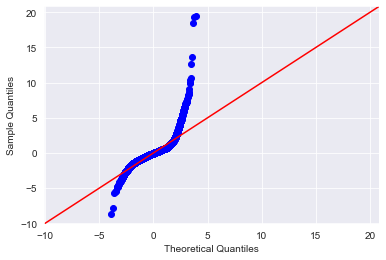

In [21]:
# Checking distribution  of errors using QQ-plot
fig = sm.graphics.qqplot(model.resid, dist='norm', line='45', fit=True)

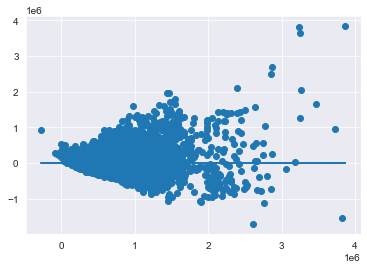

In [22]:
# Checking for homoscedasticity 

X = df.drop(to_drop, axis=1)

plt.scatter(model.predict(X), model.resid)
plt.plot(model.predict(X), [0 for i in range(len(df))])

Plot shows signs of **heteroscedasticity**. Residual errors are **not distributed normally**.

In [23]:
df1 = df.copy()

In [24]:
# before we go further, we'll create a new data frame with all of the 
# insignificant values removed
X = ['sqft_living','city','floors_1','grd_8_to_9','cond_good',
           'no_basement','waterfront_N','not_viewed','jan_mar', 
           'not_renovated','floors_3_half','apr_jun','jul_sep','oct_dec']

df1 = df1.drop(X, axis=1)

# Outliers

As we saw earlier, not only are our residuals not normal, but there are a lot of outliers. Lets trim them down.

In [25]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21420 entries, 0 to 21419
Data columns (total 27 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   price            21420 non-null  float64
 1   bedrooms         21420 non-null  int64  
 2   bathrooms        21420 non-null  float64
 3   sqft_lot         21420 non-null  int64  
 4   sqft_above       21420 non-null  int64  
 5   yr_built         21420 non-null  int64  
 6   zipcode          21420 non-null  int64  
 7   lat              21420 non-null  float64
 8   long             21420 non-null  float64
 9   sqft_living15    21420 non-null  int64  
 10  sqft_lot15       21420 non-null  int64  
 11  waterfront_Y     21420 non-null  int64  
 12  is_renovated     21420 non-null  int64  
 13  floors_2         21420 non-null  int64  
 14  floors_3         21420 non-null  int64  
 15  viewed           21420 non-null  int64  
 16  day_of_year      21420 non-null  int64  
 17  has_basement

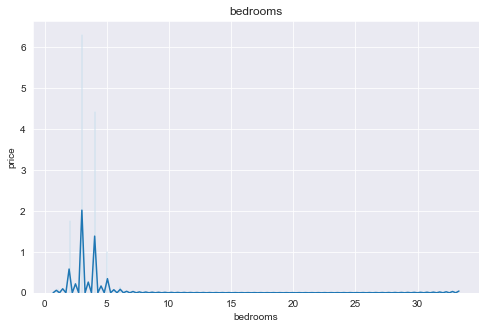

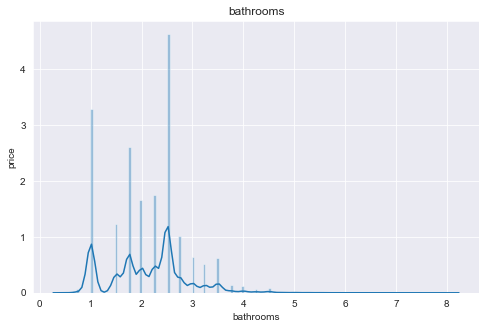

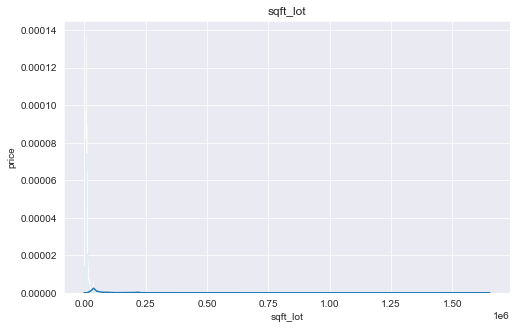

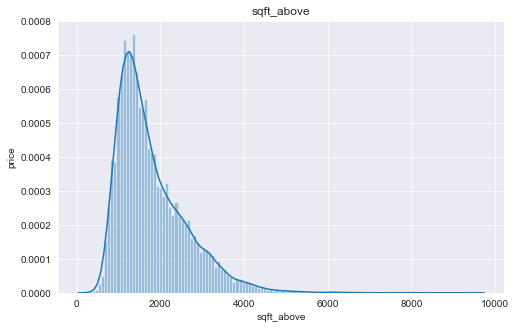

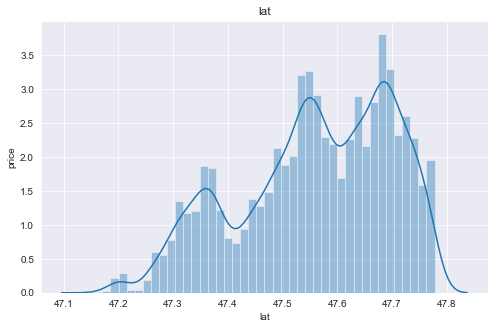

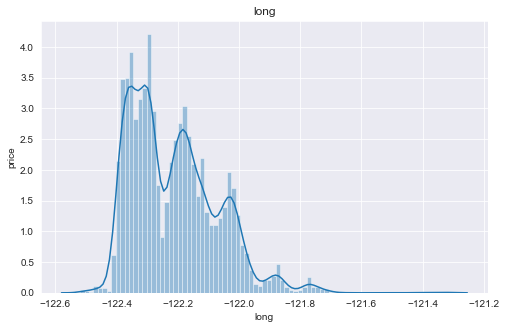

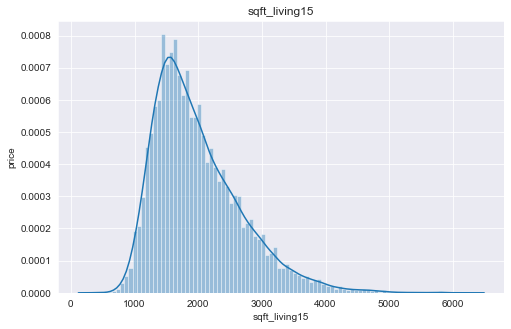

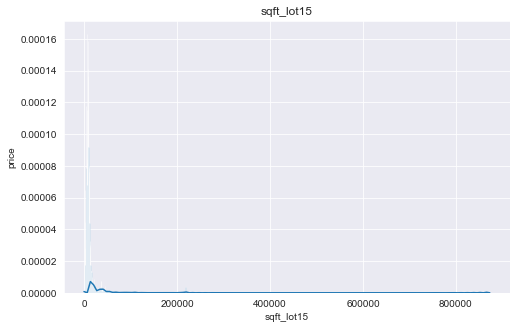

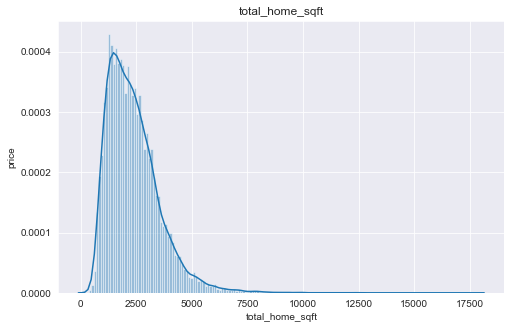

In [26]:
# We'll use a joint plot so we can also see the distribution of each feature
# as well as their relationship to the target
conts = df1[['price','bedrooms','bathrooms','sqft_lot','sqft_above','lat',
             'long','sqft_living15','sqft_lot15','total_home_sqft']]

no_price = conts.drop('price', axis=1)

for col in no_price.columns:
    plt.figure(figsize=(8,5))
    sns.distplot(conts[col], bins='auto')
    plt.title(col)
    plt.xlabel(col)
    plt.ylabel('price')
    plt.show()

Identified the features to work on, so let's get to removing outliers

## Bedrooms

<AxesSubplot:xlabel='bedrooms'>

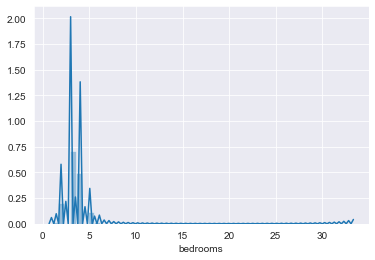

In [27]:
sns.distplot(df1['bedrooms'], kde=True)

In [28]:
# checking value counts
df1.bedrooms.value_counts()

3     9731
4     6849
2     2736
5     1586
6      265
1      191
7       38
8       13
9        6
10       3
11       1
33       1
Name: bedrooms, dtype: int64

In [29]:
# checking out the stats of these houses that have 10 or more bedrooms
# Calling original data frame, before data was normalized 
mansion = df[df['bedrooms'] >= 10]
mansion.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,sqft_above,yr_built,zipcode,lat,long,...,grd_12_to_13,jan_mar,apr_jun,jul_sep,oct_dec,cond_poor,cond_fair,cond_average,cond_good,cond_very_good
5368,640000.0,33,1.75,1620,6000,1040,47,42,47.6878,-122.331,...,0,0,1,0,0,0,0,0,0,1
11467,660000.0,10,3.00,2920,3745,1860,13,43,47.6635,-122.320,...,0,0,0,0,1,0,0,0,1,0
13598,1150000.0,10,5.25,4590,10920,2500,108,3,47.5861,-122.113,...,0,0,0,1,0,0,0,1,0,0
18364,650000.0,10,2.00,3610,11914,3010,58,5,47.5705,-122.175,...,0,0,0,0,1,0,0,0,1,0
20367,520000.0,11,3.00,3000,4960,2400,18,44,47.5560,-122.363,...,0,0,0,1,0,0,0,1,0,0


### Notes:
* The house with 33 bedrooms is clearly a **clerical error**.  A house with that is 2000 sq. ft. (with the basement) **cannot** have 33 bedrooms and 1.75 bathrooms.  The most likely explanation is human error and that this is actually a 3 bedroom home. As this is only a hypothesis, however, we'll just eliminate it along with anything else that has a z-score greater than 3. 

In [30]:
# using z-score to eliminate outliers 
df2 = df1.copy()
z = np.abs(stats.zscore(df2.bedrooms))
threshold = 3
df2 = df2[(z < 3)]

<AxesSubplot:xlabel='bedrooms'>

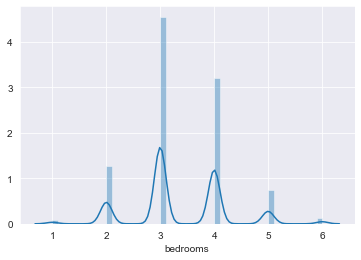

In [31]:
sns.distplot(df2['bedrooms'], label=col, kde=True)

Even though bedrooms can be considered continuous (a house can have as many rooms as the architect wants), you can make the argument that you can categorize houses by the number of bedrooms they have.  We'll change this to categorical.

In [32]:
# Changing to categorical
df2['bedrooms'] = df2['bedrooms'].astype('category')
df2['bedrooms'] = df2.bedrooms.cat.codes

## Bathrooms

2.50    5349
1.00    3793
1.75    3019
2.25    2028
2.00    1912
1.50    1427
2.75    1176
3.00     738
3.50     723
3.25     584
3.75     152
4.00     126
4.50      94
4.25      77
0.75      70
4.75      21
5.00      20
5.25      12
5.50       9
1.25       9
6.00       5
0.50       4
5.75       3
6.50       2
6.25       2
8.00       1
7.75       1
6.75       1
Name: bathrooms, dtype: int64

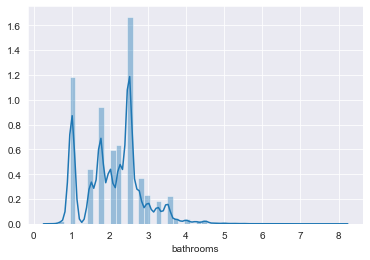

In [33]:
sns.distplot(df2['bathrooms'], label=col, kde=True)
df2.bathrooms.value_counts()

In [34]:
# We'll just do some trimming
df2 = df2[df2['bathrooms'] <= 4.00]

2.50    5349
1.00    3793
1.75    3019
2.25    2028
2.00    1912
1.50    1427
2.75    1176
3.00     738
3.50     723
3.25     584
3.75     152
4.00     126
0.75      70
1.25       9
0.50       4
Name: bathrooms, dtype: int64

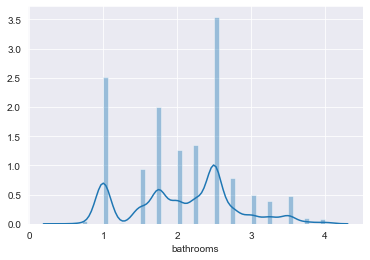

In [35]:
sns.distplot(df2['bathrooms'], label=col, kde=True)
df2.bathrooms.value_counts()

In [36]:
# Changing to categorical
df2['bathrooms'] = df2['bathrooms'].astype('category')
df2['bathrooms'] = df2.bathrooms.cat.codes

## Total_home_sqft

count    21110.000000
mean      2322.399526
std       1090.115409
min        370.000000
25%       1490.000000
50%       2150.000000
75%       2940.000000
max      10500.000000
Name: total_home_sqft, dtype: float64

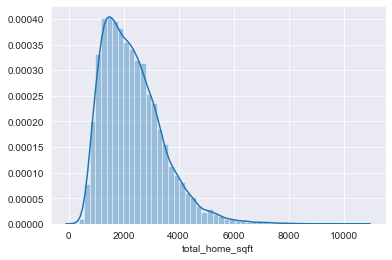

In [37]:
sns.distplot(df2['total_home_sqft'], label=col, kde=True)
df2.total_home_sqft.describe()

In [38]:
# We'll use the z-score again, but this data is pretty normal (thankfully)
z = np.abs(stats.zscore(df2.total_home_sqft))
threshold = 3
df2 = df2[(z < 3)]

<AxesSubplot:xlabel='total_home_sqft'>

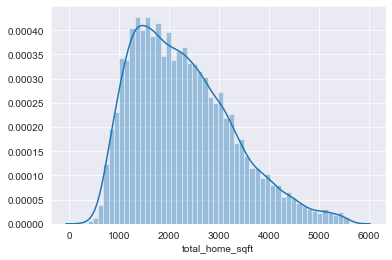

In [39]:
sns.distplot(df2['total_home_sqft'], label=col, kde=True)

## Sqft_lot

array([ 5650,  6780,  8201, ..., 16684, 18115, 18713], dtype=int64)

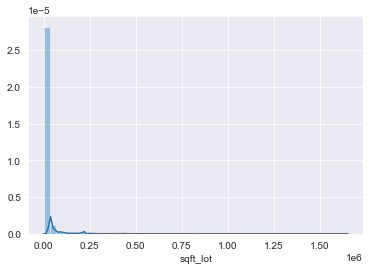

In [40]:
sns.distplot(df2['sqft_lot'], label=col, kde=True)
df2.sqft_lot.unique()

In [41]:
z = np.abs(stats.zscore(df2.sqft_lot))
threshold = 3
df2 = df2[(z < 3)]

It's a marked improvement, but if this graph represents 3 standard deviations, it might be worth dropping entirely

## Sqft_lot15

count     20562.000000
mean      10317.830902
std       15650.489569
min         651.000000
25%        5038.000000
50%        7508.000000
75%        9826.750000
max      434728.000000
Name: sqft_lot15, dtype: float64

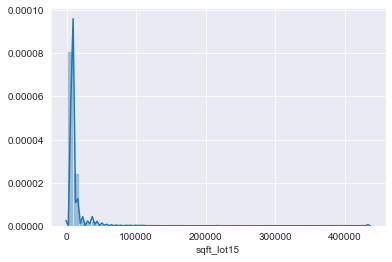

In [42]:
sns.distplot(df2['sqft_lot15'], label=col, kde=True)
df2.sqft_lot15.describe()

In [43]:
z = np.abs(stats.zscore(df2.sqft_lot15))
threshold = 3
df2 = df2[(z < 3)]

count    20287.000000
mean      8965.116133
std       7657.387711
min        651.000000
25%       5000.000000
50%       7500.000000
75%       9724.000000
max      57140.000000
Name: sqft_lot15, dtype: float64

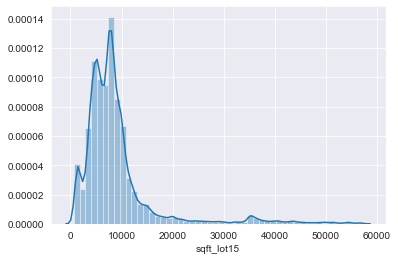

In [44]:
sns.distplot(df2['sqft_lot15'], label=col, kde=True)
df2.sqft_lot15.describe()

## Log Transformation

These plots still look pretty non-normal, so let's perform a log transformation and see if we can improve this.

In [45]:
# creating a new data frame for the log transformations
# bedrooms and 
log_df = df2.copy()
log_df = log_df.rename({'sqft_lot': 'log_sqft_lot',
                     'sqft_above':'log_sqft_above',
                     'total_home_sqft':'log_total_home_sqft',
                      'sqft_living15':'log_sqft_living15',
                      'sqft_lot15':'log_sqft_lot15'}, axis=1)

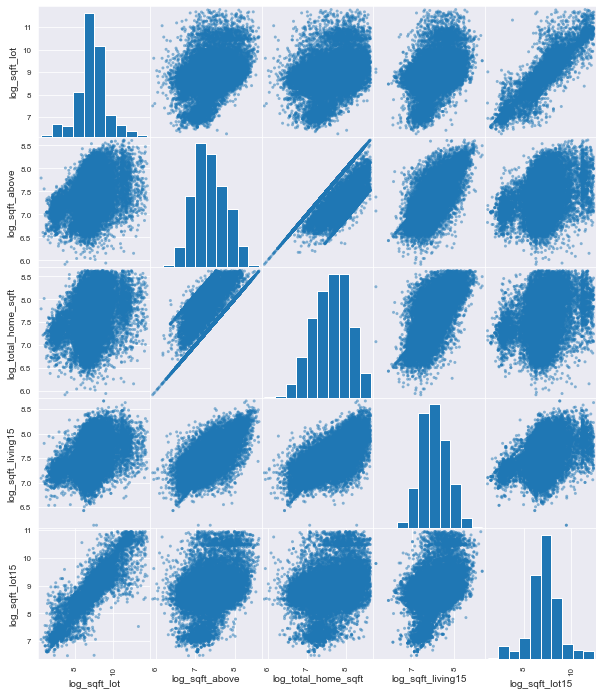

In [46]:
#transforming 
revised_logs = ['log_sqft_lot','log_sqft_above','log_total_home_sqft',
                'log_sqft_living15','log_sqft_lot15']

for log in revised_logs:
    log_df[log] = log_df[log].map(lambda x : np.log(x))
    log_df[log] = log_df[log].rename({log : 'log_'+log})
pd.plotting.scatter_matrix(log_df[revised_logs], figsize=(10,12));

In [47]:
conts = ['log_sqft_lot','log_sqft_above','log_total_home_sqft',
                'log_sqft_living15','log_sqft_lot15']

In [48]:
def norm_feat(series):
    """
    Input a series containing continuous variables.
    Outputs a normalized version of the data
    """
    return (series - series.mean())/series.std()

for feat in conts:
    log_df[feat] = norm_feat(log_df[feat])

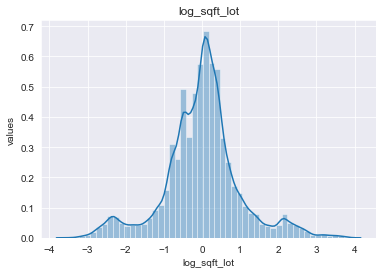

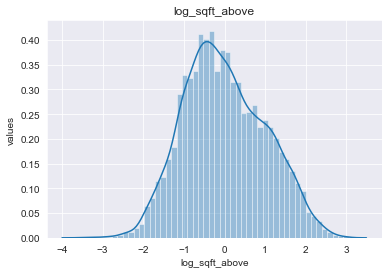

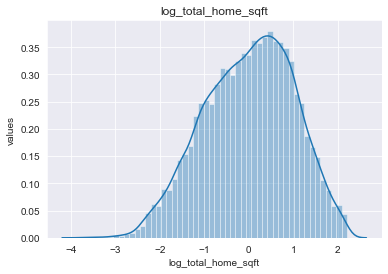

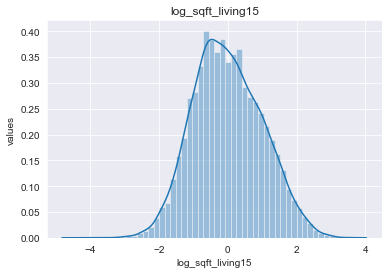

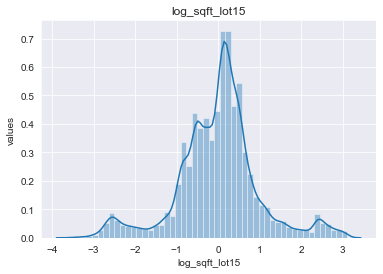

In [49]:
for col in conts: 
    sns.distplot(log_df[col], label=[col])
    plt.xlabel(col)
    plt.ylabel('values')
    plt.title(col)
    plt.show()

They look...interesting...but let's model it and calculate the RMSE.

In [50]:
target = 'price'

feats = log_df.drop('price', axis=1).columns
preds = '+'.join(feats)

formula = target + '~' + preds
model = smf.ols(formula=formula, data=log_df).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                               Results: Ordinary least squares
=============================================================================================
Model:                       OLS                      Adj. R-squared:             0.673      
Dependent Variable:          price                    AIC:                        546148.6045
Date:                        2021-02-25 12:12         BIC:                        546362.3833
No. Observations:            20287                    Log-Likelihood:             -2.7305e+05
Df Model:                    26                       F-statistic:                1610.      
Df Residuals:                20260                    Prob (F-statistic):         0.00       
R-squared:                   0.674                    Scale:                      2.8750e+10 
---------------------------------------------------------------------------------------------
                        Coef.        Std.Err.      t     P>|t|      [0.025         0.975]    
---------------------------------------------------------------------------------------------
Intercept           -45222830.2682 1524577.1046 -29.6625 0.0000 -48211125.0102 -42234535.5261
bedrooms               -13076.0313    1877.8793  -6.9632 0.0000    -16756.8269     -9395.2356
bathrooms               11121.2550     756.1135  14.7084 0.0000      9639.2112     12603.2988
log_sqft_lot            -8683.7145    3025.8352  -2.8699 0.0041    -14614.5967     -2752.8322
log_sqft_above          85928.2684    3715.2158  23.1287 0.0000     78646.1442     93210.3926
yr_built                -2286.1100      61.1617 -37.3782 0.0000     -2405.9918     -2166.2282
zipcode                 -1432.4309      78.2558 -18.3045 0.0000     -1585.8186     -1279.0432
lat                    625841.0486    9481.1029  66.0093 0.0000    607257.3182    644424.7790
long                  -132301.2355   11610.8371 -11.3946 0.0000   -155059.4177   -109543.0533
log_sqft_living15       42671.9354    2008.9480  21.2409 0.0000     38734.2344     46609.6363
log_sqft_lot15         -14569.9548    2958.9970  -4.9240 0.0000    -20369.8288     -8770.0808
waterfront_Y           586275.4784   17041.0612  34.4037 0.0000    552873.6167    619677.3402
is_renovated            14433.5558    2944.4882   4.9019 0.0000      8662.1203     20204.9914
floors_2                -4269.1732    3571.9420  -1.1952 0.2320    -11270.4691      2732.1226
floors_3                29086.4341    7958.2930   3.6549 0.0003     13487.5346     44685.3337
viewed                 124939.1705    4656.6107  26.8305 0.0000    115811.8361    134066.5050
day_of_year              -102.2162      12.6085  -8.1069 0.0000      -126.9299       -77.5024
has_basement            50825.5420    5551.6123   9.1551 0.0000     39943.9317     61707.1524
log_total_home_sqft     14508.9796    3752.5163   3.8665 0.0001      7153.7434     21864.2158
grd_1_to_5             -92327.5297   11943.6880  -7.7302 0.0000   -115738.1266    -68916.9327
grd_6_to_7             -86165.0428    3344.5996 -25.7624 0.0000    -92720.7293    -79609.3564
grd_10_to_11           305605.7246    5803.7697  52.6564 0.0000    294229.8655    316981.5837
grd_12_to_13           756602.9018   28678.8913  26.3819 0.0000    700389.9495    812815.8541
cond_poor              -90194.9415   32961.5691  -2.7364 0.0062   -154802.2895    -25587.5936
cond_fair              -37940.3841   14358.7078  -2.6423 0.0082    -66084.6156     -9796.1526
cond_average           -27851.9670    3023.6061  -9.2115 0.0000    -33778.4801    -21925.4540
cond_very_good          43325.8265    4903.9188   8.8349 0.0000     33713.7480     52937.9049
---------------------------------------------------------------------------------------------
Omnibus:                     10699.389              Durbin-Watson:                 1.327     
Prob(Omnibus):               0.000                  Jarque-Bera (JB):              177416.772
Skew:                        2.157

In [51]:
y = log_df['price']
x_cols = log_df.drop('price', axis=1)

X_train, X_test, y_train, y_test = train_test_split(x_cols, y, test_size=0.3, 
                                                    random_state=42)

In [52]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [53]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 28882318043.050835
Test Mean Squarred Error: 28381572259.51479


In [54]:
# Caluclating Root Mean Squared Error
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)

Train RMSE: 169947.98628713092
Test RMSE: 168468.3123305828


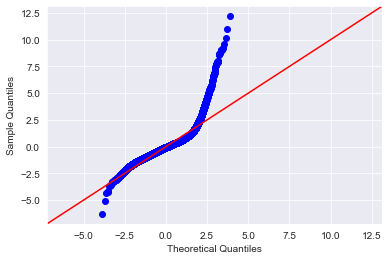

In [55]:
# Checking distribution  of errors using QQ-plot
fig = sm.graphics.qqplot(model.resid, dist='norm', line='45', fit=True)

### Initial Analysis

So far we can see that the RMSE for both the test and training data sets are relatively close.  So we know that so far, the model (despite its flaws) is not over trained.  It still has an root mean squared error of 165,000.  This isn't great, but it is not horrible in context. Given the price range of the data we're dealing with (between 78,000-3.4 million), being off by 165,000 isn't too bad on the higher end of the spectrum.  It does make it a poor estimator of lower prices.  This is could be due to the fact that there was still great deal of outliers in our residual errors, even after trimming them down. It could also be due to the fact that the residuals also don't follow a normal distribution.  

Before we commit to this, let's see if we can improve our model any further through step-wise selection.

# Step-Wise Selection

In [56]:
# Using step-wise selection to eliminate any remaining statistically 
# insignificant features based on their p-values

def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    """ Perform a forward-backward feature selection 
    based on p-value from statsmodels.api.OLS
    Arguments:
        X - pandas.DataFrame with candidate features
        y - list-like with the target
        initial_list - list of features to start with (column names of X)
        threshold_in - include a feature if its p-value < threshold_in
        threshold_out - exclude a feature if its p-value > threshold_out
        verbose - whether to print the sequence of inclusions and exclusions
    Returns: list of selected features 
    Always set threshold_in < threshold_out to avoid infinite looping.
    See https://en.wikipedia.org/wiki/Stepwise_regression for the details
    """
    included = list(initial_list)
    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))

        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            included.remove(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature, worst_pval))
        if not changed:
            break
    return included

In [57]:
features = log_df.drop('price', axis=1)

result = stepwise_selection(features, log_df['price'], verbose=True)
print('resulting features:')
print(result)

Add  grd_6_to_7                     with p-value 0.0
Add  bathrooms                      with p-value 0.0
Add  log_sqft_living15              with p-value 0.0
Add  lat                            with p-value 0.0
Add  waterfront_Y                   with p-value 0.0
Add  yr_built                       with p-value 0.0
Add  grd_10_to_11                   with p-value 0.0
Add  grd_12_to_13                   with p-value 4.5946e-147
Add  viewed                         with p-value 1.49115e-145
Add  log_sqft_above                 with p-value 1.43201e-170
Add  has_basement                   with p-value 1.89093e-105
Add  log_sqft_lot15                 with p-value 1.82245e-50
Add  zipcode                        with p-value 3.29971e-58
Add  cond_average                   with p-value 6.5413e-38
Add  long                           with p-value 2.84995e-35
Add  cond_very_good                 with p-value 1.56643e-19
Add  grd_1_to_5                     with p-value 1.1701e-17
Add  day_of_year  

In [59]:
# lets see what results we get when we use these suggested features

suggested = log_df[['price', 'grd_6_to_7', 'bathrooms', 'log_sqft_living15', 
                    'lat', 'waterfront_Y', 'yr_built', 'grd_10_to_11', 
                    'grd_12_to_13', 'viewed', 'log_sqft_above', 
                    'has_basement', 'log_sqft_lot15', 'zipcode', 
                    'cond_average', 'long', 'cond_very_good', 'grd_1_to_5', 
                    'day_of_year', 'bedrooms', 'is_renovated', 'floors_3', 
                    'log_total_home_sqft', 'log_sqft_lot', 'cond_poor', 
                    'cond_fair']]

target = 'price'

feats = suggested.drop(['price'], axis=1).columns
preds = '+'.join(feats)

formula2 = target + '~' + preds
model2 = smf.ols(formula=formula2, data=log_df).fit()
model2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                               Results: Ordinary least squares
=============================================================================================
Model:                       OLS                      Adj. R-squared:             0.673      
Dependent Variable:          price                    AIC:                        546148.0348
Date:                        2021-02-25 12:14         BIC:                        546353.8959
No. Observations:            20287                    Log-Likelihood:             -2.7305e+05
Df Model:                    25                       F-statistic:                1674.      
Df Residuals:                20261                    Prob (F-statistic):         0.00       
R-squared:                   0.674                    Scale:                      2.8751e+10 
---------------------------------------------------------------------------------------------
                        Coef.        Std.Err.      t     P>|t|      [0.025         0.975]    
---------------------------------------------------------------------------------------------
Intercept           -45334868.1382 1521708.6156 -29.7921 0.0000 -48317540.4003 -42352195.8761
grd_6_to_7             -85959.9222    3340.2289 -25.7347 0.0000    -92507.0416    -79412.8028
bathrooms               10978.0639     746.5696  14.7047 0.0000      9514.7270     12441.4007
log_sqft_living15       42724.1940    2008.4934  21.2718 0.0000     38787.3842     46661.0038
lat                    626109.3447    9478.5453  66.0554 0.0000    607530.6275    644688.0620
waterfront_Y           585421.8821   17026.2689  34.3835 0.0000    552049.0146    618794.7496
yr_built                -2281.1475      61.0212 -37.3829 0.0000     -2400.7540     -2161.5410
grd_10_to_11           305642.7652    5803.7483  52.6630 0.0000    294266.9480    317018.5824
grd_12_to_13           757005.7763   28677.2135  26.3975 0.0000    700796.1128    813215.4399
viewed                 125105.8569    4654.5710  26.8781 0.0000    115982.5204    134229.1934
log_sqft_above          84199.7537    3422.2113  24.6039 0.0000     77491.9421     90907.5654
has_basement            50551.5758    5546.9367   9.1134 0.0000     39679.1301     61424.0215
log_sqft_lot15         -14323.3050    2951.8231  -4.8524 0.0000    -20109.1177     -8537.4923
zipcode                 -1440.2777      77.9807 -18.4697 0.0000     -1593.1263     -1287.4292
cond_average           -28107.3766    3016.0769  -9.3192 0.0000    -34019.1318    -22195.6213
long                  -133104.6784   11591.4836 -11.4830 0.0000   -155824.9260   -110384.4308
cond_very_good          43254.1661    4903.6041   8.8209 0.0000     33642.7045     52865.6277
grd_1_to_5             -92654.1596   11940.6873  -7.7595 0.0000   -116058.8749    -69249.4443
day_of_year              -102.3451      12.6082  -8.1173 0.0000      -127.0582       -77.6319
bedrooms               -13093.1629    1877.8444  -6.9724 0.0000    -16773.8902     -9412.4356
is_renovated            14458.1144    2944.4476   4.9103 0.0000      8686.7584     20229.4705
floors_3                33246.1577    7156.9933   4.6453 0.0000     19217.8705     47274.4449
log_total_home_sqft     15233.1632    3703.3147   4.1134 0.0000      7974.3661     22491.9602
log_sqft_lot            -8141.7450    2991.6960  -2.7214 0.0065    -14005.7117     -2277.7782
cond_poor              -90642.1231   32959.7940  -2.7501 0.0060   -155245.9917    -26038.2546
cond_fair              -38027.0493   14358.6765  -2.6484 0.0081    -66171.2195     -9882.8792
---------------------------------------------------------------------------------------------
Omnibus:                     10713.448              Durbin-Watson:                 1.326     
Prob(Omnibus):               0.000                  Jarque-Bera (JB):              178116.615
Skew:                        2.160                  Prob(JB):                      0.000     
Kurtosis:                    16.85

In [60]:
x_cols = suggested.drop(['price'], axis=1)
y = log_df['price']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_cols, y, test_size=0.3, 
                                                    random_state=42)

In [61]:
from sklearn.linear_model import LinearRegression
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [62]:
#calculating the Mean Squared error
from sklearn.metrics import mean_squared_error

train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 28883670443.14382
Test Mean Squarred Error: 28385005918.63134


In [63]:
# Caluclating Root Mean Squared Error
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)

Train RMSE: 169951.96510527268
Test RMSE: 168478.50283828896


### Results
Well, there is no difference in the RMSE by using Step-wise Selection. Even though Step-wise gave us a better adjusted R-squared. It did remove one feature, making our model a slightly less complex. Let's keep this for now and move on.

## Cross Validation

In [64]:
df3 = suggested.copy()

In [65]:
# cross validating our model for consistency
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score

x_cols = df3.drop(['price'], axis=1)
y = df3['price']

cv_5_results  = np.mean(cross_val_score(linreg, x_cols, y, cv=5,  
                                        scoring='neg_mean_squared_error'))
cv_10_results = np.mean(cross_val_score(linreg, x_cols, y, cv=10, 
                                        scoring='neg_mean_squared_error'))
cv_20_results = np.mean(cross_val_score(linreg, x_cols, y, cv=20, 
                                        scoring='neg_mean_squared_error'))

In [66]:
print("Mean CV 5 results: ", cv_5_results.mean())
print("Mean CV 10 results: ", cv_10_results.mean())
print("Mean CV 20 results: ", cv_20_results.mean())
print('Train MSE: ', train_mse)
print('Test MSE: ',test_mse )

Mean CV 5 results:  -31035866059.690228
Mean CV 10 results:  -30729991464.861855
Mean CV 20 results:  -30767265097.22474
Train MSE:  28883670443.14382
Test MSE:  28385005918.63134


By comparison, the difference between the Cross Validation means and our MSE values are close, but not close enough. Let's go ahead and see if we can tighten up these values by including interactions.

In [67]:
# for easy reference, we'll calculate our baseline r-squared 

from sklearn.model_selection import KFold

regression = LinearRegression()

crossvalidation = KFold(n_splits=10, shuffle=True, random_state=42)
baseline_r_sqr = np.mean(cross_val_score(regression, x_cols, y, scoring='r2', 
                                   cv=crossvalidation))

baseline_r_sqr

0.6719902057777292

# Interactions
Let's see if we can improve our model fit any more and lower our RMSE by including interactions.

In [68]:
features = df3.drop('price', axis=1)

In [69]:
from itertools import combinations

interactions = []

feat_combinations = combinations(features.columns, 2)

data = features.copy()

# for loop that takes a copy of our data frame, retrieves the columns and 
# multiplies them together, evaluates the mean of the cross-validation of the 
# model with the interactions present.  If the score is greater than the 
# baseline it will be added to the list of interactions, with their score

for i, (a, b) in enumerate(feat_combinations):
    data['interaction'] = data[a] * data[b]
    score = np.mean(cross_val_score(regression, data, y, scoring='r2', 
                                    cv=crossvalidation))
    if score > baseline_r_sqr:
        interactions.append((a, b, round(score,3)))
    
    if i % 50 == 0:
        print(i)
            
print('Top 3 interactions: %s' %sorted(interactions, 
                                       key=lambda inter: inter[2], 
                                       reverse=True)[:3])

0
50
100
150
200
250
Top 3 interactions: [('log_sqft_above', 'log_total_home_sqft', 0.688), ('bathrooms', 'log_sqft_above', 0.685), ('bathrooms', 'log_total_home_sqft', 0.685)]


## Adding Interactions

In [70]:
regression = LinearRegression()
crossvalidation = KFold(n_splits=10, shuffle=True, random_state=1)

final = df3.copy()

final['log_sqft_above*log_total_home_sqft'] = (final['log_sqft_above'] * 
                                               final['log_total_home_sqft'])

final['bathrooms*log_total_home_sqft'] = (final['bathrooms'] * 
                                          final['log_total_home_sqft'])

final['bathrooms*log_sqft_above'] = final['bathrooms'] * final['log_sqft_above']

fin_x = final.drop('price', axis=1)

final_model = np.mean(cross_val_score(regression, fin_x, y, scoring='r2', cv=crossvalidation))

final_model

0.6896512957714721

Ok, our R-squared went up, so let's test this out.

## Applying to Model

In [71]:
target = 'price'

feats = fin_x.columns

preds = '+'.join(feats)

formula = target + '~' + preds
model = smf.ols(formula=formula, data=final).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                      Results: Ordinary least squares
============================================================================================================
Model:                            OLS                           Adj. R-squared:                  0.691      
Dependent Variable:               price                         AIC:                             545026.9351
Date:                             2021-02-25 12:15              BIC:                             545256.5494
No. Observations:                 20287                         Log-Likelihood:                  -2.7248e+05
Df Model:                         28                            F-statistic:                     1622.      
Df Residuals:                     20258                         Prob (F-statistic):              0.00       
R-squared:                        0.691                         Scale:                           2.7201e+10 
------------------------------------------------------------------------------------------------------------
                                       Coef.        Std.Err.      t     P>|t|      [0.025         0.975]    
------------------------------------------------------------------------------------------------------------
Intercept                          -44706179.8754 1482532.8872 -30.1553 0.0000 -47612064.5593 -41800295.1914
grd_6_to_7                            -80870.9838    3268.0378 -24.7460 0.0000    -87276.6029    -74465.3647
bathrooms                               9039.3635     736.9513  12.2659 0.0000      7594.8792     10483.8478
log_sqft_living15                      38621.1070    1961.5840  19.6887 0.0000     34776.2433     42465.9708
lat                                   617952.9273    9228.8692  66.9587 0.0000    599863.5952    636042.2593
waterfront_Y                          588935.3454   16564.1302  35.5549 0.0000    556468.3070    621402.3839
yr_built                               -2119.6386      60.0041 -35.3249 0.0000     -2237.2514     -2002.0258
grd_10_to_11                          232493.7385    6062.3790  38.3502 0.0000    220610.9842    244376.4929
grd_12_to_13                          592321.8830   28360.0057  20.8858 0.0000    536733.9720    647909.7939
viewed                                117820.3735    4549.7628  25.8959 0.0000    108902.4694    126738.2777
log_sqft_above                         53407.3247    5691.1273   9.3843 0.0000     42252.2536     64562.3958
has_basement                           38946.7643    5448.1276   7.1487 0.0000     28267.9923     49625.5362
log_sqft_lot15                        -16797.9252    2872.5243  -5.8478 0.0000    -22428.3059    -11167.5446
zipcode                                -1627.3237      76.1536 -21.3690 0.0000     -1776.5910     -1478.0565
cond_average                          -32750.7312    2940.5720 -11.1375 0.0000    -38514.4909    -26986.9715
long                                 -131022.8690   11287.7635 -11.6075 0.0000   -153147.8008   -108897.9373
cond_very_good                         41695.9638    4772.3920   8.7369 0.0000     32341.6885     51050.2390
grd_1_to_5                           -173028.2250   11895.8933 -14.5452 0.0000   -196345.1406   -149711.3095
day_of_year                             -101.8562      12.2658  -8.3041 0.0000      -125.8982       -77.8141
bedrooms                              -12727.0110    1837.8559  -6.9249 0.0000    -16329.3577     -9124.6643
is_renovated                           14540.6570    2864.0219   5.0770 0.0000      8926.9418     20154.3723
floors_3                               47012.1645    6984.9177   6.7305 0.0000     33321.1594     60703.1696
log_total_home_sqft                    21308.1249    5819.4270   3.6616 0.0003      9901.5760     32714.6737
log_sqft_lot                          -10002.9483    2911.6160  -3.4355 0.0006    -15709.9518     -4295.9449
cond_poor                             -99340.6321   32060.6678  -3

### Calculating RMSE 

In [72]:
x_cols = fin_x
y = final['price']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_cols, y, test_size=0.3, 
                                                    random_state=42)

In [73]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [74]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 27339706555.404896
Test Mean Squarred Error: 26814780027.679974


In [75]:
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)
print('Train RMSE:', train_rmse)
print('Test RMSE:', test_rmse)

Train RMSE: 165347.2302622723
Test RMSE: 163752.1909095569


RMSE has improved a good amount! Let's cross validate it!

# Cross-Validating Final Model

In [76]:
x_cols = fin_x
y = final['price']

cv_5_results  = np.mean(cross_val_score(linreg, x_cols, y, cv=5,  
                                        scoring='neg_mean_squared_error'))
cv_10_results = np.mean(cross_val_score(linreg, x_cols, y, cv=10, 
                                        scoring='neg_mean_squared_error'))
cv_20_results = np.mean(cross_val_score(linreg, x_cols, y, cv=20, 
                                        scoring='neg_mean_squared_error'))

In [77]:
print("Root Mean CV 5 results: ", np.sqrt(abs(cv_5_results.mean())))
print("Root CV 10 results: ", np.sqrt(abs(cv_10_results.mean())))
print("Root CV 20 results: ", np.sqrt(abs(cv_20_results.mean())))
print('Train RMSE: ', train_rmse)
print('Test RMSE: ',test_rmse)

Root Mean CV 5 results:  171610.504879384
Root CV 10 results:  170642.95354911164
Root CV 20 results:  170741.24234816292
Train RMSE:  165347.2302622723
Test RMSE:  163752.1909095569


## Results:
These results look pretty good considering where we have come from! Let's take a look at our model and its QQ-plot one last time.

In [78]:
target = 'price'

feats = fin_x.columns

preds = '+'.join(feats)

formula = target + '~' + preds
model = smf.ols(formula=formula, data=final).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                      Results: Ordinary least squares
============================================================================================================
Model:                            OLS                           Adj. R-squared:                  0.691      
Dependent Variable:               price                         AIC:                             545026.9351
Date:                             2021-02-25 12:16              BIC:                             545256.5494
No. Observations:                 20287                         Log-Likelihood:                  -2.7248e+05
Df Model:                         28                            F-statistic:                     1622.      
Df Residuals:                     20258                         Prob (F-statistic):              0.00       
R-squared:                        0.691                         Scale:                           2.7201e+10 
------------------------------------------------------------------------------------------------------------
                                       Coef.        Std.Err.      t     P>|t|      [0.025         0.975]    
------------------------------------------------------------------------------------------------------------
Intercept                          -44706179.8754 1482532.8872 -30.1553 0.0000 -47612064.5593 -41800295.1914
grd_6_to_7                            -80870.9838    3268.0378 -24.7460 0.0000    -87276.6029    -74465.3647
bathrooms                               9039.3635     736.9513  12.2659 0.0000      7594.8792     10483.8478
log_sqft_living15                      38621.1070    1961.5840  19.6887 0.0000     34776.2433     42465.9708
lat                                   617952.9273    9228.8692  66.9587 0.0000    599863.5952    636042.2593
waterfront_Y                          588935.3454   16564.1302  35.5549 0.0000    556468.3070    621402.3839
yr_built                               -2119.6386      60.0041 -35.3249 0.0000     -2237.2514     -2002.0258
grd_10_to_11                          232493.7385    6062.3790  38.3502 0.0000    220610.9842    244376.4929
grd_12_to_13                          592321.8830   28360.0057  20.8858 0.0000    536733.9720    647909.7939
viewed                                117820.3735    4549.7628  25.8959 0.0000    108902.4694    126738.2777
log_sqft_above                         53407.3247    5691.1273   9.3843 0.0000     42252.2536     64562.3958
has_basement                           38946.7643    5448.1276   7.1487 0.0000     28267.9923     49625.5362
log_sqft_lot15                        -16797.9252    2872.5243  -5.8478 0.0000    -22428.3059    -11167.5446
zipcode                                -1627.3237      76.1536 -21.3690 0.0000     -1776.5910     -1478.0565
cond_average                          -32750.7312    2940.5720 -11.1375 0.0000    -38514.4909    -26986.9715
long                                 -131022.8690   11287.7635 -11.6075 0.0000   -153147.8008   -108897.9373
cond_very_good                         41695.9638    4772.3920   8.7369 0.0000     32341.6885     51050.2390
grd_1_to_5                           -173028.2250   11895.8933 -14.5452 0.0000   -196345.1406   -149711.3095
day_of_year                             -101.8562      12.2658  -8.3041 0.0000      -125.8982       -77.8141
bedrooms                              -12727.0110    1837.8559  -6.9249 0.0000    -16329.3577     -9124.6643
is_renovated                           14540.6570    2864.0219   5.0770 0.0000      8926.9418     20154.3723
floors_3                               47012.1645    6984.9177   6.7305 0.0000     33321.1594     60703.1696
log_total_home_sqft                    21308.1249    5819.4270   3.6616 0.0003      9901.5760     32714.6737
log_sqft_lot                          -10002.9483    2911.6160  -3.4355 0.0006    -15709.9518     -4295.9449
cond_poor                             -99340.6321   32060.6678  -3

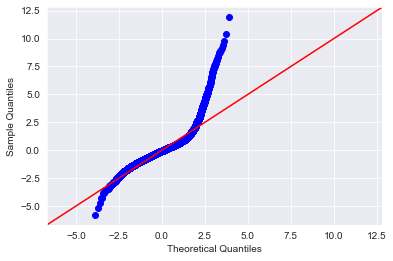

In [79]:
fig = sm.graphics.qqplot(model.resid, dist='norm', line='45', fit=True)

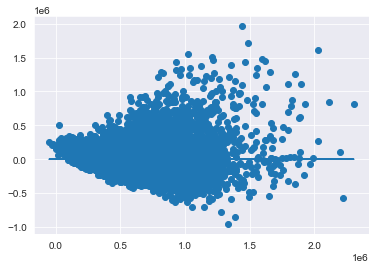

In [80]:
plt.scatter(model.predict(fin_x), model.resid)
plt.plot(model.predict(fin_x), [0 for i in range(len(final))])

# Log Transformation of Price 
Testing out model performance after performing log transformation on target variable 'price'

In [81]:
final['price'] = final['price'].map(lambda x : np.log(x))

In [82]:
final = final.rename({'price':'log_price'}, axis=1)

In [83]:
# remodeling
target = 'log_price'

feats = fin_x.columns

preds = '+'.join(feats)

formula = target + '~' + preds
model = smf.ols(formula=formula, data=final).fit()
model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                           Results: Ordinary least squares
======================================================================================
Model:                      OLS                    Adj. R-squared:           0.749    
Dependent Variable:         log_price              AIC:                      1108.1505
Date:                       2021-02-25 12:16       BIC:                      1337.7648
No. Observations:           20287                  Log-Likelihood:           -525.08  
Df Model:                   28                     F-statistic:              2166.    
Df Residuals:               20258                  Prob (F-statistic):       0.00     
R-squared:                  0.750                  Scale:                    0.061749 
--------------------------------------------------------------------------------------
                                    Coef.   Std.Err.    t     P>|t|   [0.025   0.975] 
--------------------------------------------------------------------------------------
Intercept                          -65.4014   2.2337 -29.2793 0.0000 -69.7797 -61.0232
grd_6_to_7                          -0.1750   0.0049 -35.5342 0.0000  -0.1846  -0.1653
bathrooms                            0.0155   0.0011  13.9512 0.0000   0.0133   0.0177
log_sqft_living15                    0.0859   0.0030  29.0788 0.0000   0.0801   0.0917
lat                                  1.4487   0.0139 104.1825 0.0000   1.4214   1.4759
waterfront_Y                         0.5469   0.0250  21.9118 0.0000   0.4979   0.5958
yr_built                            -0.0035   0.0001 -38.3648 0.0000  -0.0036  -0.0033
grd_10_to_11                         0.2250   0.0091  24.6355 0.0000   0.2071   0.2429
grd_12_to_13                         0.3966   0.0427   9.2820 0.0000   0.3129   0.4804
viewed                               0.1647   0.0069  24.0329 0.0000   0.1513   0.1782
log_sqft_above                       0.0937   0.0086  10.9285 0.0000   0.0769   0.1105
has_basement                         0.0515   0.0082   6.2782 0.0000   0.0354   0.0676
log_sqft_lot15                      -0.0422   0.0043  -9.7537 0.0000  -0.0507  -0.0337
zipcode                             -0.0019   0.0001 -16.5353 0.0000  -0.0021  -0.0017
cond_average                        -0.0576   0.0044 -13.0020 0.0000  -0.0663  -0.0489
long                                -0.0808   0.0170  -4.7535 0.0000  -0.1142  -0.0475
cond_very_good                       0.0629   0.0072   8.7522 0.0000   0.0488   0.0770
grd_1_to_5                          -0.4076   0.0179 -22.7417 0.0000  -0.4427  -0.3725
day_of_year                         -0.0002   0.0000  -9.5152 0.0000  -0.0002  -0.0001
bedrooms                            -0.0240   0.0028  -8.6519 0.0000  -0.0294  -0.0185
is_renovated                         0.0158   0.0043   3.6663 0.0002   0.0074   0.0243
floors_3                             0.0421   0.0105   4.0039 0.0001   0.0215   0.0628
log_total_home_sqft                  0.0945   0.0088  10.7792 0.0000   0.0773   0.1117
log_sqft_lot                        -0.0136   0.0044  -3.0909 0.0020  -0.0222  -0.0050
cond_poor                           -0.2637   0.0483  -5.4584 0.0000  -0.3584  -0.1690
cond_fair                           -0.1808   0.0211  -8.5877 0.0000  -0.2221  -0.1396
log_sqft_above:log_total_home_sqft   0.0221   0.0031   7.2174 0.0000   0.0161   0.0282
bathrooms:log_total_home_sqft       -0.0009   0.0011  -0.8862 0.3755  -0.0030   0.0011
bathrooms:log_sqft_above             0.0038   0.0011   3.3853 0.0007   0.0016   0.0059
--------------------------------------------------------------------------------------
Omnibus:                     302.732             Durbin-Watson:                1.247  
Prob(Omnibus):               0.000               Jarque-Bera (JB):             581.011
Skew:                        0.028               Prob(JB):                     0.000  
Kurtosis:                    3.827               Condition No.: 

In [84]:
x_cols = fin_x
y = final['log_price']
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(x_cols, y, test_size=0.3, 
                                                    random_state=42)

In [85]:
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

In [86]:
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)
print('Train Mean Squarred Error:', train_mse)
print('Test Mean Squarred Error:', test_mse)

Train Mean Squarred Error: 0.06159168858353283
Test Mean Squarred Error: 0.06202143735614535


## Calculating Price in Terms of Dollars

In [87]:
# inversing the Log transformation on predictions vs. actual to compare RMSE
real_y_hat_test = np.exp(y_hat_test)
real_y_test = np.exp(y_test)

In [88]:
mse_test = np.sum((real_y_test - real_y_hat_test)**2)/len(real_y_test)
round(np.sqrt(mse_test),2)

160647.28

Our RMSE with the log transformation on price has dropped considerably.  The model is capable of predicting a house price within $148,000.  

Let's look at the QQ-plot and check for homoscedasticity.

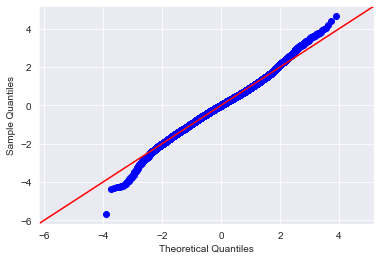

In [89]:
# Checking the residual errors
fig = sm.graphics.qqplot(model.resid, dist='norm', line='45', fit=True)

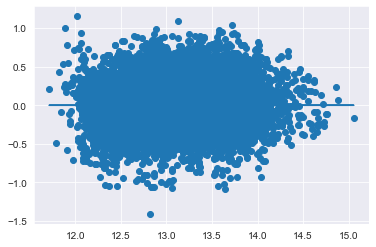

In [90]:
plt.scatter(model.predict(fin_x), model.resid)
plt.plot(model.predict(fin_x), [0 for i in range(len(final))])

# Analysis

According to the model, the following variables have the strongest impact on a home's price in King County:

* The grade that King County gave the home, especially if it was above a 9. This is a separate grading system established by King County that is separate from the condition of the home.  

* Location. Specifically whether or not you live in Quadrant 1, the Bellevue area.

* Whether or not you live on the waterfront.  Aside from paying to have a beautiful view, this could also be because most of the waterfront property is in the northeast section of King County (Quadrant 1). Strangely though, this appears to have a negative effect on the price, with a slope of -1 million.

This model still has a long way to go.  It is consistent, but there are still too many outliers and the residuals are not adhering to the assumptions of normality.  

In its current state, the model is only acceptable for estimating the more expensive homes in King County.